In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from dataloader import get_dataloaders
from models.msdnet import MSDNet
from utils import parse_args
from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import pandas as pd
import glob
import os
import shutil

from tqdm import tqdm

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0.1 ImageNet extract and folder setup

In [2]:
# images = glob.glob("data/image_net/valid/*.JPEG")

# labels = pd.read_csv('data/image_net/valid/labels_kaggle_with_names.csv', index_col=0)
# labels.columns = ["image_id", "label", "name"]

# # make class folders (with names)
# for _name in labels["name"].unique():
#     try:
#         os.mkdir(f'data/image_net/valid/{_name}')
#     except Exception as e:
#         print(i)
#         print(e)

# # extract number from the image name, e.g. 'data/image_net/valid/ILSVRC2012_val_00013964.JPEG' -> 13964
# images_id = [int(image.split('/')[-1].split('.')[0].split('_')[-1]) for image in images]

# # move images to folder labels
# for id, path in zip(images_id, images):
#     label = labels[labels["image_id"] == id]["name"].values[0]
#     name = path.split('/')[-1]
#     try:
#         shutil.move(f'data/image_net/valid/{name}', f'data/image_net/valid/{label}/{name}')
#     except Exception as e:
#         print(id)
#         print(e)

In [3]:
# for label in range(1, 1001):
#     images = glob.glob(f"data/image_net/valid/{label}/*.JPEG")
#     images_id = [int(image.split('/')[-1].split('.')[0].split('_')[-1]) for image in images]
#     for id, path in zip(images_id, images):
#         name = path.split('/')[-1]
#         try:
#             shutil.move(f'data/image_net/valid/{label}/{name}', f'data/image_net/valid/{name}')
#         except Exception as e:
#             print(id)
#             print(e)

In [4]:
# for label in range(1, 1001):
#     os.rmdir(f'/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/data/image_net/valid/{label}')

# 0.2 Load pretrained model

In [5]:
# CIFAR-100
ARGS = parse_args()
ARGS.data_root = 'data'
ARGS.data = 'ImageNet'
ARGS.save= f'/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/image_net'
ARGS.arch = 'msdnet'
ARGS.batch_size = 64
ARGS.epochs = 90
ARGS.nBlocks = 5
ARGS.stepmode = 'even'
ARGS.base = 4
ARGS.nChannels = 32
ARGS.growthRate = 16
ARGS.bnFactor = [1, 2, 4, 4]
ARGS.grFactor = [1, 2, 4, 4]
ARGS.j = 16
ARGS.num_classes = 1000
ARGS.step = 4
ARGS.use_valid = True
ARGS.splits = ['train', 'val', 'test']
ARGS.likelihood = 'softmax'
ARGS.nScales = len(ARGS.grFactor)


DATA_PATH = 'data/image_net/valid/'

In [6]:
# load pre-trained model
model = MSDNet(args=ARGS)
MODEL_PATH = f'image_net/msdnet-step=4-block=5.pth.tar'
state = torch.load(MODEL_PATH)
params = OrderedDict()
for params_name, params_val in state['state_dict'].items():
    params[params_name.replace('module.', '')] = params_val
    # state['state_dict'][params_name.replace('module.', '')] = state['state_dict'].pop(params_name)
model.load_state_dict(params)
model = model.cuda()
model.eval()

building network of steps: 
[4, 4, 4, 4, 4] 20
 ********************** Block 1  **********************
|		inScales 4 outScales 4 inChannels 32 outChannels 16		|

|		inScales 4 outScales 4 inChannels 48 outChannels 16		|

|		inScales 4 outScales 4 inChannels 64 outChannels 16		|

|		inScales 4 outScales 4 inChannels 80 outChannels 16		|

 ********************** Block 2  **********************
|		inScales 4 outScales 4 inChannels 96 outChannels 16		|

|		inScales 4 outScales 3 inChannels 112 outChannels 16		|
|		Transition layer inserted! (max), inChannels 128, outChannels 64	|

|		inScales 3 outScales 3 inChannels 64 outChannels 16		|

|		inScales 3 outScales 3 inChannels 80 outChannels 16		|

 ********************** Block 3  **********************
|		inScales 3 outScales 3 inChannels 96 outChannels 16		|

|		inScales 3 outScales 3 inChannels 112 outChannels 16		|

|		inScales 3 outScales 2 inChannels 128 outChannels 16		|
|		Transition layer inserted! (max), inChannels 144, outChannels

MSDNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): MSDNFirstLayer(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (1): ConvBasic(
            (net): Sequential(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (2): ConvBasic(
            (net): Sequential(
              (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

In [7]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'nr. of trainable params: {params}')

nr. of trainable params: 23958440


In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_set = datasets.ImageFolder(DATA_PATH, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize
        ]))

In [9]:
val_loader = torch.utils.data.DataLoader(
                val_set,
                batch_size=ARGS.batch_size, shuffle=False,
                num_workers=ARGS.workers, pin_memory=True)

In [10]:
logits = []
targets = []
with torch.no_grad():
    for i, (x, y) in tqdm(enumerate(val_loader)):
        y = y.cuda(device=None)
        x = x.cuda()

        input_var = torch.autograd.Variable(x)
        target_var = torch.autograd.Variable(y)

        output = model(input_var)
        if not isinstance(output, list):
            output = [output]

        logits.append(torch.stack(output))
        targets.append(target_var)

logits = torch.cat(logits, dim=1).cpu()
targets = torch.cat(targets).cpu()

782it [02:05,  6.21it/s]


In [11]:
# sanity check for labels
for i in range(10):
    print(torch.mode(targets[50*i:50*(i+1)]).values, torch.mode(torch.argmax(logits, dim=2)[-1, :][50*i:50*(i+1)]).values)

tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(2) tensor(2)
tensor(3) tensor(3)
tensor(4) tensor(4)
tensor(5) tensor(5)
tensor(6) tensor(6)
tensor(7) tensor(7)
tensor(8) tensor(8)
tensor(9) tensor(9)


# 1 Anytime Performance

In [12]:
L = len(logits)
N = 10000

In [13]:
ids = random.sample(range(50000), N)
logits = logits[:, ids, :]
targets = targets[ids]

In [14]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [15]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5.])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [16]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5.])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [17]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]

In [18]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}

In [25]:
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]

In [26]:
acc_poe_ovr

[tensor(0.0014),
 tensor(0.0016),
 tensor(0.0018),
 tensor(0.0018),
 tensor(0.0019)]

In [19]:
probs_poe_ovr_break_ties = f_probs_ovr_poe_break_ties(logits, probs_poe_ovr)
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

100%|██████████| 5/5 [16:58<00:00, 203.68s/it]


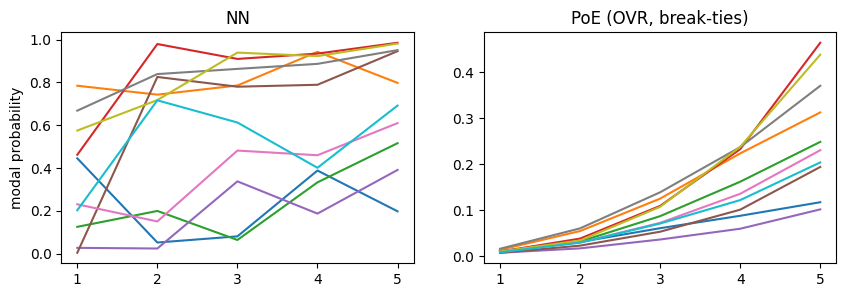

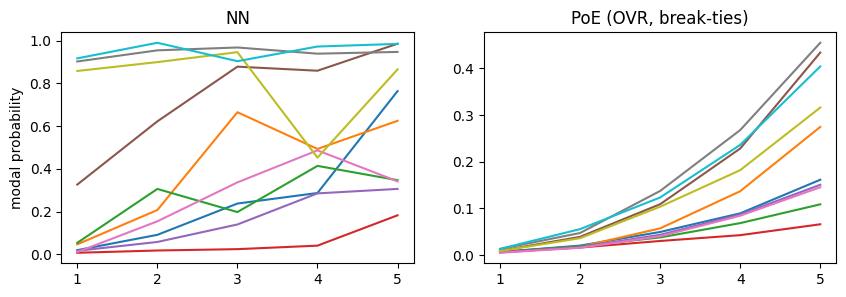

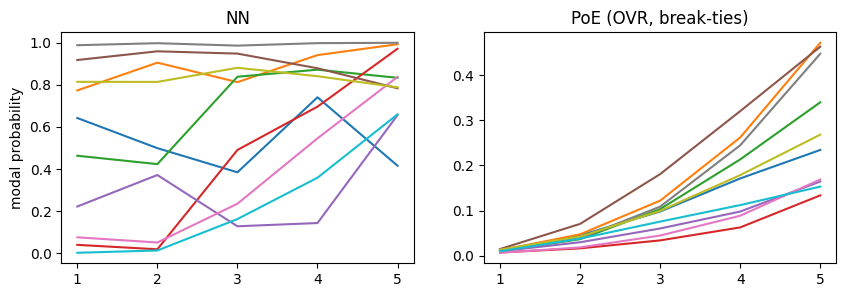

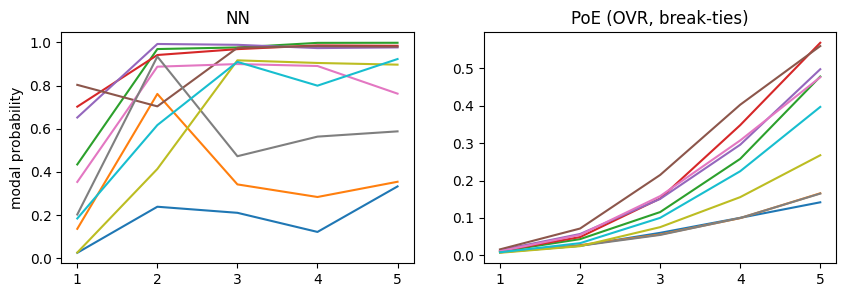

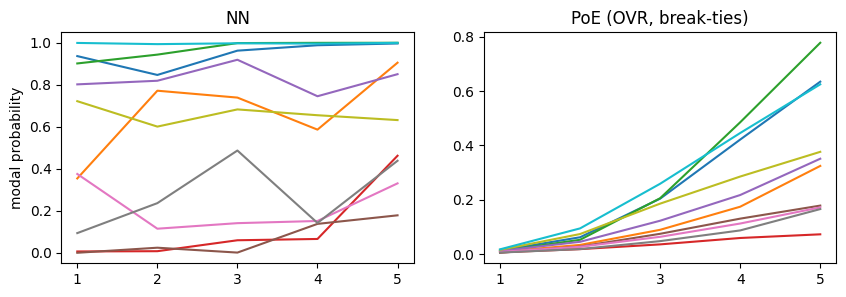

In [20]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    samples = random.sample(range(N), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('NN')
    ax[1].set_title('PoE (OVR, break-ties)')
    ax[0].set_ylabel('modal probability')
    plt.show()

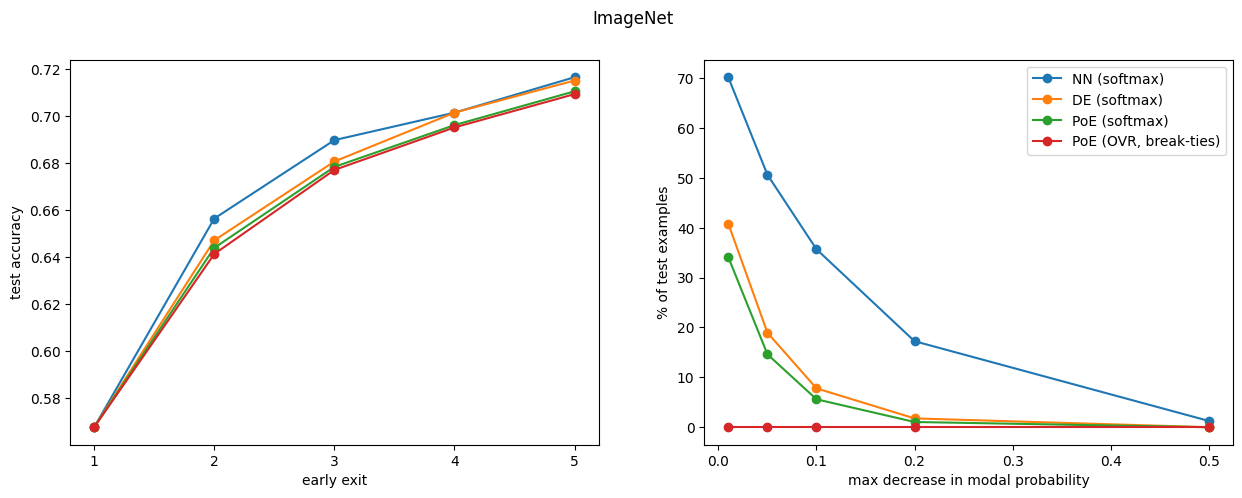

In [29]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
ax[0].plot(early_exits, acc_de, label='DE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe, label='PoE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (OVR, break-ties)', marker='o')
# ax[0].plot(early_exits, acc_poe_ovr, label='PoE (OVR)', marker='o')
ax[0].set_xlabel('early exit')
ax[0].set_ylabel('test accuracy')
ax[0].set_xticks([1., 2., 3., 4., 5.], [1, 2, 3, 4, 5])

for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_de, probs_de, 'DE (softmax)'), 
                            (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                            # (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            # (preds_ovr_break_ties, probs_ovr_break_ties, 'NN (OVR, break-ties)'),
                            # (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle('ImageNet')
plt.show()

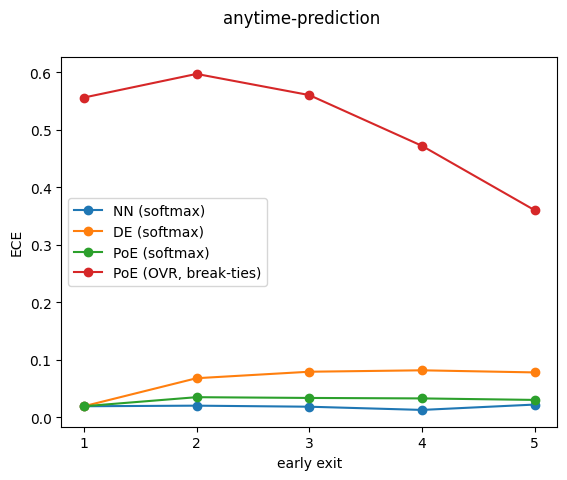

In [31]:
early_exits = [i + 1 for i in range(len(acc))]
for _probs, label in [
                      (probs, 'NN (softmax)'),  
                      (probs_de, 'DE (softmax)'), 
                      (probs_poe, 'PoE (softmax)'),
                      # (probs_poe_ovr, 'PoE (OVR)'),
                      (probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                      # (probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                      ]:
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    plt.plot(early_exits, ece, marker='o', label=label)
plt.legend()
plt.xlabel('early exit')
plt.ylabel('ECE')
plt.xticks([1., 2., 3., 4., 5.], [1, 2, 3, 4, 5])

plt.suptitle('anytime-prediction')
plt.show()

# 2 Misc

## 2.1 Plot ImageNet

In [23]:
# for j, (x, y) in enumerate(val_loader):
#     # plot test images
#     for i in range(10):
#         plt.imshow(x[i, :, :, :].cpu().permute(1, 2, 0))
#         plt.title(f'{y[i]}')
#         plt.axis('off')
#         plt.show()
#     if j > 1:
#         break